In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from utils import annotated_heatmap

# Corridor environment

In [2]:
class CorridorEnv:
    def __init__(self, n_states=3, is_slippery = False):
        self.nS = n_states
        self.nA = 3
        self.is_slippery = is_slippery
        self.s = 0
        self.prob = 0.75
        self.terminal_s = self.nS-1        
        self.model = {}
        for s in range(self.nS):
            self.model[s] = {}
            for a in range(self.nA):
                self.s = s
                s_, dropped = self.step(a)
                p1 = self.prob
                p2 = 1 - self.prob
                r = -10 if dropped else -1 
                d = bool(s == self.terminal_s)
                self.model[s][a] = [(p1, s_, r, d), (p2, np.int64(s), r, d)] if self.is_slippery else [(1.0, s_, r, d)]
        
        
    def reset(self):
        self.s = 0
        
    def step(self, a):
        if a == 0: # LEFT
            shift = -1
        elif a == 1: # DON'T MOVE
            shift = 0
        elif a == 2:
            shift = +1 # RIGHT
        else:
            raise

        if self.is_slippery:
            self.s = np.random.choice([self.s+shift, self.s], p=[self.prob, 1 - self.prob])
        else:
            self.s += shift
            
        dropped = (self.s<0 or self.s>=self.nS)
        return np.clip(self.s, 0, self.nS-1), dropped

In [3]:
env = CorridorEnv(n_states=5, is_slippery=False)

n_states = env.nS
n_actions = env.nA
P_model = env.model

gamma = 1.0
height, width = 4, 12

# Random policy
# policy = np.ones((n_states, n_actions)) / n_actions

# Deterministic policy
policy = [[0, 0, 1]]*n_states

# Policy Evaluation

In [4]:
def bellman_update(V, pi, s, transitions):
    value = 0
    V = deepcopy(V)
    for a in range(n_actions):
        for p, s_, r, done in transitions[s][a]:
            value += pi[s][a]*p*(r + gamma*(V[s_]))*(not done)
    V[s] = value
    return value
    
def policy_evaluation(V, policy, transitions):
    count = 0
    theta = 10
    delta = np.inf
    while delta > theta:
        count+=1
        delta = 0.0
        V_prev = deepcopy(V)
        for s in range(n_states):
            v = bellman_update(V_prev, policy, s, transitions)
            V[s] = v
            delta = max(delta, abs(v - V_prev[s]))
    return V

# Policy Improvement

In [5]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        if q_values[i] > top_value:
            top_value = q_values[i]
            ties = [i]
        elif q_values[i] == top_value:
            ties.append(i)
    return np.random.choice(ties)

def greedify_policy(V, pi, s, transitions):
    q = np.zeros(n_actions)
    for a in range(n_actions):
        for p, s_, r, done in transitions[s][a]:
            q[a] += p*(r + gamma*V[s_])*(not done)
    a_max = argmax(q)
    for a in range(n_actions):
        pi[s][a] = 1.0 if a == a_max else 0.0

def policy_improvement(pi, V, transitions):
    policy_stable = True
    for s in range(n_states):
        old_pi = pi[s].copy()
        greedify_policy(V, pi, s, transitions)
        if not np.array_equal(old_pi, pi[s]):
            policy_stable = False
    return policy_stable        

# Policy Iteration

In [6]:
def policy_iteration():
    V = np.zeros(n_states)
    pi = [np.ones(n_actions)/n_actions]*n_states # Set the policy to a uniform distribution
    # pi = policy
    policy_converged = False
    while not policy_converged:
        V = policy_evaluation(V, pi, P_model)
        policy_converged = policy_improvement(pi, V, P_model)
    return V, pi

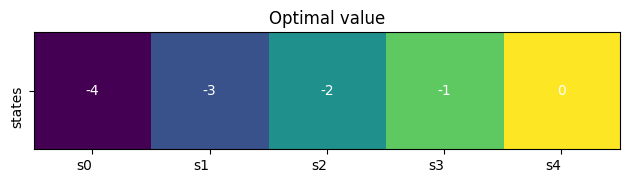

Optimal policy
s0: [0. 0. 1.]
s1: [0. 0. 1.]
s2: [0. 0. 1.]
s3: [0. 0. 1.]
s4: [0. 0. 1.]


In [12]:
V, pi = policy_iteration()
annotated_heatmap([V], "Optimal value")
print("Optimal policy")
for s, actions in enumerate(pi):
    print("s"+str(s)+":", actions)

# Value Iteration

In [8]:
def value_iteration():
    a = env.action_space.sample()
    Q = np.zeros((n_states, n_actions))
    for s in env.observation_space:
        delta = np.inf
        while delta > 0.01:
            s_new, r, terminated, truncated, info = env.step(a)
            delta = bellman_update(Q, s, a, r, s_new)
            greedify_policy(q, pi, s)

In [9]:
value_iteration()

AttributeError: 'CorridorEnv' object has no attribute 'action_space'